# 📊 Análise de Crédito com Modelos Preditivos

## Contexto
Conceder crédito é sempre um equilíbrio delicado: de um lado, a instituição deseja ampliar o número de clientes aprovados; de outro, precisa minimizar o risco de inadimplência.  
O objetivo desta análise foi **identificar quais fatores influenciam mais a classificação de um cliente em "bom" ou "mau pagador"**, e avaliar diferentes modelos preditivos para apoiar a tomada de decisão.

In [40]:
!pip install mlflow

import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, roc_curve
)
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


In [41]:
credito = pd.read_csv(r'/home/wallingson12/Github/Data science and ML/Análise de crédito/credit.csv')

print(f"Colunas:{credito.columns}")

print(f"Número de linhas: {credito.shape[0]}")
print(f"Número de colunas: {credito.shape[1]}")

Colunas:Index(['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class'], dtype='object')
Número de linhas: 1000
Número de colunas: 21


In [127]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


# Abordagem
Para responder a essas perguntas, seguimos três etapas principais:

1. **Preparação dos dados**  
   - Seleção de variáveis como status da conta, histórico de crédito, valor solicitado, tempo de residência, idade, emprego, entre outras. 
   - Transformação de variáveis categóricas em numéricas e normalização para equilibrar as escalas.  
   - Separação dos dados em treino (70%) e teste (30%).  

2. **Modelagem**  
   Foram testados diferentes algoritmos de classificação:  
   - **Regressão Logística**  
   - **Árvore de Decisão**  
   - **SVM (Support Vector Machine)**  
   - **Random Forest**  
   - **Rede Neural Artificial**  

3. **Avaliação e Interpretabilidade**  
   - Utilização de métricas de acurácia, precisão, recall e F1-Score.  
   - Uso do **SHAP** e dos **coeficientes dos modelos lineares** para entender a importância das variáveis.  


In [134]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap

# # Selecionar variáveis preditoras específicas e alvo
variaveis_selecionadas = ['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker']

# Assumindo que 'credito' seja o DataFrame com os dados
X = credito[variaveis_selecionadas]
y = credito["class"]  # Apenas a variável alvo

# Converter variáveis categóricas em numéricas com get_dummies
X = pd.get_dummies(X, drop_first=False)

# Verificar as colunas após o get_dummies para garantir que as variáveis estejam corretas
print("Colunas após o get_dummies:")
print(X.columns)  # Exibe as colunas criadas após o get_dummies()

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelos
logistic_model = LogisticRegression()
decision_tree_model = DecisionTreeClassifier()
svm_model = SVC()
random_forest_model = RandomForestClassifier(random_state=42)

# Treinamento dos modelos
logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Predições
y_pred_logistic = logistic_model.predict(X_test)
y_pred_tree = decision_tree_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_forest = random_forest_model.predict(X_test)

# Avaliação dos Modelos
results = {
    "Regressão Logística": {
        "Acurácia": accuracy_score(y_test, y_pred_logistic),
        "Precisão": precision_score(y_test, y_pred_logistic, average='weighted'),
        "Recall": recall_score(y_test, y_pred_logistic, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_logistic, average='weighted')
    },
    "Árvore de Decisão": {
        "Acurácia": accuracy_score(y_test, y_pred_tree),
        "Precisão": precision_score(y_test, y_pred_tree, average='weighted'),
        "Recall": recall_score(y_test, y_pred_tree, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_tree, average='weighted')
    },
    "SVM": {
        "Acurácia": accuracy_score(y_test, y_pred_svm),
        "Precisão": precision_score(y_test, y_pred_svm, average='weighted'),
        "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_svm, average='weighted')
    },
    "Random Forest": {
        "Acurácia": accuracy_score(y_test, y_pred_forest),
        "Precisão": precision_score(y_test, y_pred_forest, average='weighted'),
        "Recall": recall_score(y_test, y_pred_forest, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_forest, average='weighted')
    }
}

# Exibir Resultados
results_df = pd.DataFrame(results).T
print(results_df)

Colunas após o get_dummies:
Index(['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'checking_status_0<=X<200', 'checking_status_<0', 'checking_status_>=200', 'checking_status_no checking', 'credit_history_all paid', 'credit_history_critical/other existing credit', 'credit_history_delayed previously', 'credit_history_existing paid', 'credit_history_no credits/all paid', 'purpose_business', 'purpose_domestic appliance', 'purpose_education', 'purpose_furniture/equipment', 'purpose_new car', 'purpose_other', 'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining', 'purpose_used car', 'savings_status_100<=X<500', 'savings_status_500<=X<1000', 'savings_status_<100', 'savings_status_>=1000', 'savings_status_no known savings', 'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1', 'employment_>=7', 'employment_unemployed', 'other_parties_co applicant', 'other_parties_guarantor', 'other_parties_none', 'property_magnitude_car',
       

In [135]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [132]:
credito['num_dependents'].unique()

array([1., 2.])

## Análise de Importância de Variáveis

Com o objetivo de compreender quais variáveis exercem maior influência nas predições dos modelos e fundamentar a redução do espaço de atributos, foi realizada uma análise de importância das variáveis utilizando abordagens específicas para cada algoritmo empregado.

Inicialmente, as variáveis foram avaliadas no nível de categorias (dummies), permitindo identificar padrões locais e globais de contribuição ao resultado do modelo.
    
Em seguida, essas contribuições foram interpretadas e agregadas ao nível das variáveis originais, de forma a preservar a interpretabilidade e reduzir a complexidade do modelo.

Para a Árvore de Decisão, foi utilizada a metodologia SHAP (SHapley Additive exPlanations), que permite quantificar a contribuição de cada variável para a predição de instâncias individuais, evidenciando tanto o impacto quanto a direção da influência de cada atributo.

No caso da Regressão Logística, a importância das variáveis foi avaliada por meio dos coeficientes estimados pelo modelo, considerando seu sinal e magnitude como indicadores da influência positiva ou negativa sobre a variável alvo.

Para o modelo SVM, adotou-se a versão com kernel linear, possibilitando a interpretação direta dos coeficientes do hiperplano separador, de forma análoga à regressão logística.

A partir dessas análises, foram selecionadas as variáveis originais que concentraram maior contribuição explicativa, justificando a exclusão de atributos redundantes ou de baixo impacto, resultando em modelos mais simples, interpretáveis e com menor risco de overfitting.

**ANÁLISE DE VARIÁVEIS COM SHAP - DECISION TREE**



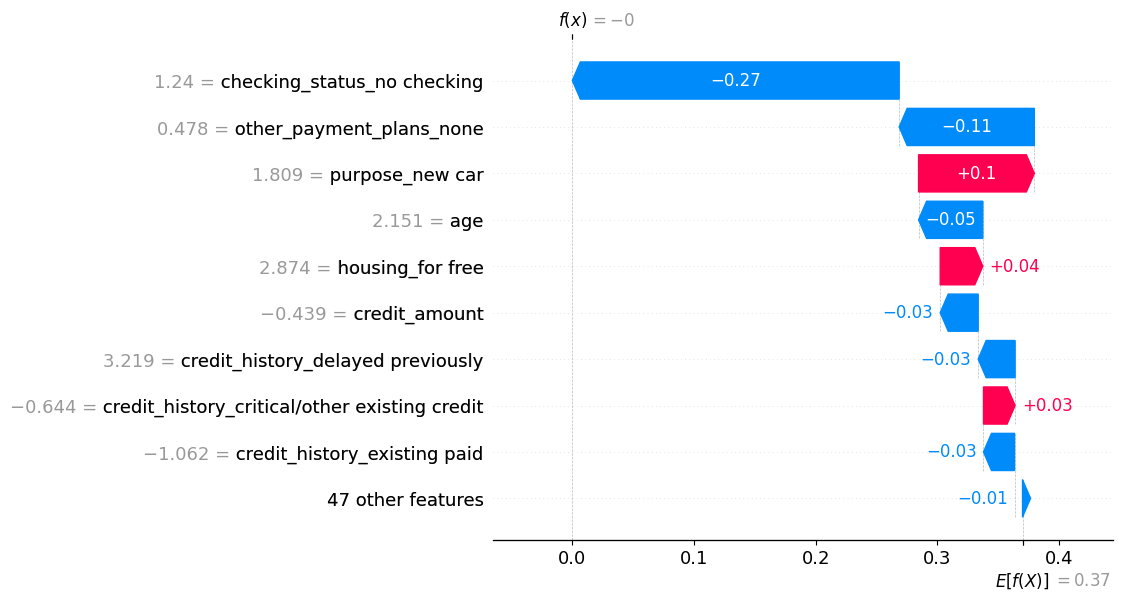

In [182]:
explainer = shap.Explainer(decision_tree_model, X_train)
shap_values = explainer(X_train)

# Supondo que X é seu DataFrame original com os nomes das features
feature_names = X.columns.tolist()

# Extrair os valores para a primeira instância e o primeiro output
single_values = shap_values.values[0, :, 0]         # vetor dos valores SHAP (1D)
single_base = shap_values.base_values[0, 0]           # valor base escalar
single_data = shap_values.data[0]                     # dados da instância

# Criar uma nova explicação incluindo os nomes das features
single_explanation = shap.Explanation(
    values=single_values,
    base_values=single_base,
    data=single_data,
    feature_names=feature_names
)

# Plotar o waterfall com os nomes das features
shap.plots.waterfall(single_explanation)

**ANÁLISE DE VARIÁVEIS COM SHAP - REGRESSION LOGISTIC**

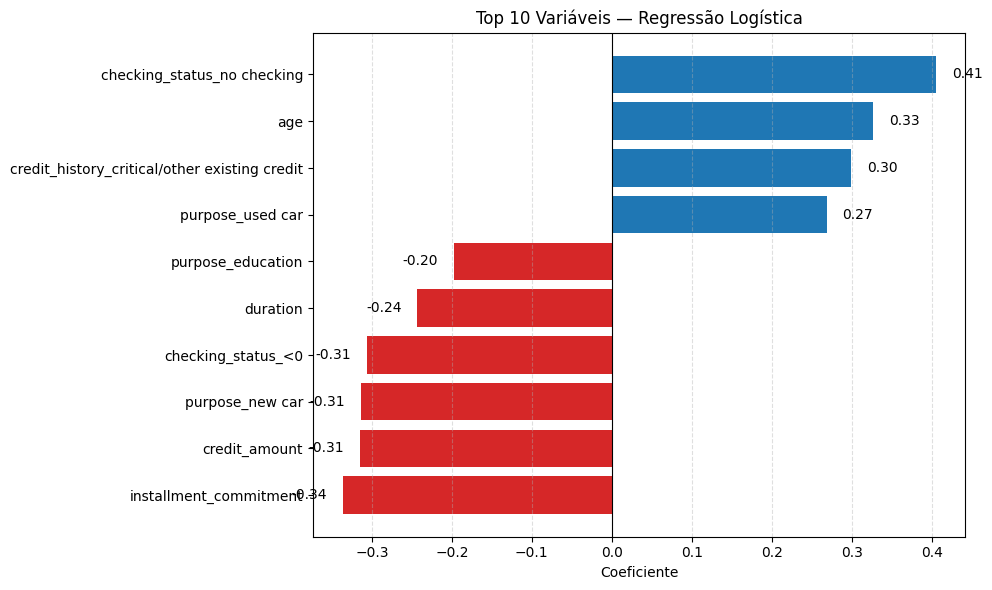


IMPORTÂNCIA DAS VARIÁVEIS (ORDENADO)

                   Variável                    Coeficiente  Importância (abs)
                  checking_status_no checking    0.40517        0.405165     
                       installment_commitment   -0.33675        0.336748     
                                          age    0.32637        0.326371     
                                credit_amount   -0.31437        0.314375     
                              purpose_new car   -0.31332        0.313324     
                           checking_status_<0   -0.30657        0.306567     
credit_history_critical/other existing credit    0.29958        0.299577     
                             purpose_used car    0.26861        0.268611     
                                     duration   -0.24313        0.243128     
                            purpose_education   -0.19774        0.197744     
                 credit_history_existing paid   -0.18557        0.185574     
                      cre

In [184]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Coeficientes
coef = logistic_model.coef_[0]
features = X.columns

# DataFrame completo
coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coef
})

# Importância absoluta
coef_df['Importância (abs)'] = coef_df['Coeficiente'].abs()

# =====================
# 📊 GRÁFICO — TOP 10
# =====================
top10 = (
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .head(10)
    .sort_values(by='Coeficiente')
)

colors = top10['Coeficiente'].apply(
    lambda x: '#1f77b4' if x > 0 else '#d62728'
)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    top10['Variável'],
    top10['Coeficiente'],
    color=colors
)

plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Coeficiente')
plt.title('Top 10 Variáveis — Regressão Logística')
plt.grid(axis='x', linestyle='--', alpha=0.4)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + np.sign(width) * 0.02,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}',
        va='center',
        ha='left' if width > 0 else 'right'
    )

plt.tight_layout()
plt.show()


# =====================
# 📋 PRINT — TODAS
# =====================
print('\nIMPORTÂNCIA DAS VARIÁVEIS (ORDENADO)\n')
print(
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .assign(Coeficiente=lambda x: x['Coeficiente'].round(5))
    [['Variável', 'Coeficiente', 'Importância (abs)']]
    .to_string(index=False)
)

**ANÁLISE DE VARIÁVEIS COM SHAP - SVM**

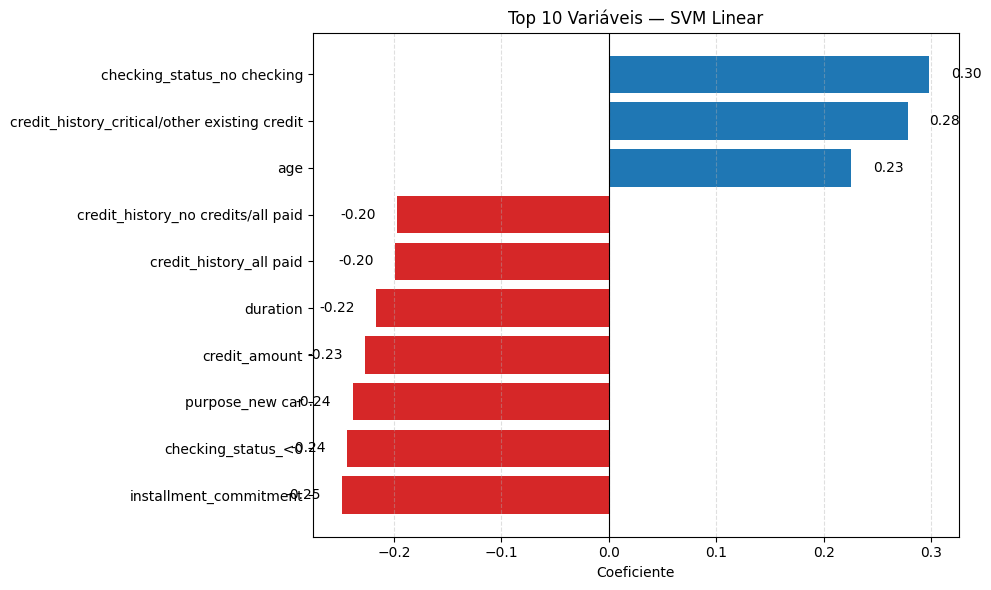


IMPORTÂNCIA DAS VARIÁVEIS — SVM LINEAR

                   Variável                    Coeficiente  Importância (abs)
                  checking_status_no checking    0.29828        0.298283     
credit_history_critical/other existing credit    0.27813        0.278131     
                       installment_commitment   -0.24802        0.248020     
                           checking_status_<0   -0.24321        0.243212     
                              purpose_new car   -0.23833        0.238326     
                                credit_amount   -0.22723        0.227229     
                                          age    0.22556        0.225560     
                                     duration   -0.21644        0.216444     
                      credit_history_all paid   -0.19895        0.198950     
           credit_history_no credits/all paid   -0.19672        0.196721     
                            purpose_education   -0.17061        0.170612     
                       

In [185]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =====================
# TREINO DO MODELO
# =====================
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# =====================
# COEFICIENTES
# =====================
coef = svm_model.coef_[0]   # binário
features = X.columns

coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coef
})

coef_df['Importância (abs)'] = coef_df['Coeficiente'].abs()

# =====================
# 📊 GRÁFICO — TOP 10
# =====================
top10 = (
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .head(10)
    .sort_values(by='Coeficiente')
)

colors = top10['Coeficiente'].apply(
    lambda x: '#1f77b4' if x > 0 else '#d62728'
)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    top10['Variável'],
    top10['Coeficiente'],
    color=colors
)

plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Coeficiente')
plt.title('Top 10 Variáveis — SVM Linear')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Valores nos bares
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + np.sign(width) * 0.02,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}',
        va='center',
        ha='left' if width > 0 else 'right'
    )

plt.tight_layout()
plt.show()

# =====================
# 📋 PRINT — TODAS
# =====================
print('\nIMPORTÂNCIA DAS VARIÁVEIS — SVM LINEAR\n')
print(
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .assign(Coeficiente=lambda x: x['Coeficiente'].round(5))
    [['Variável', 'Coeficiente', 'Importância (abs)']]
    .to_string(index=False)
)

# Testando a performqance do modelo apenas aplicando as colunas que parecem ter cse destacado

In [188]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =====================================================
# TARGET
# =====================================================
y = credito['class']

# =====================================================
# 1️⃣ REGRESSÃO LOGÍSTICA – VARIÁVEIS PURAS
# (derivadas das dummies mais relevantes)
# =====================================================

features_logistic = [
    'checking_status',
    'installment_commitment',
    'age',
    'credit_amount',
    'purpose',
    'duration',
    'credit_history'
]

X_log = credito[features_logistic]

# Dummyficar (apesar de aqui serem numéricas, mantém padrão)
X_log = pd.get_dummies(X_log, drop_first=True)

# Escalonamento
scaler_log = StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)

# Split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    X_log_scaled, y, test_size=0.3, random_state=42
)

# Modelo
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(Xl_train, yl_train)

# Predição
y_pred_log = logistic_model.predict(Xl_test)

# =====================================================
# 2️⃣ SVM – VARIÁVEIS PURAS
# =====================================================

features_svm = [
    'checking_status',
    'credit_history',
    'installment_commitment',
    'purpose',
    'credit_amount',
    'age',
    'duration'
]

X_svm = credito[features_svm]

# Dummyficar
X_svm = pd.get_dummies(X_svm, drop_first=True)

# Escalonamento
scaler_svm = StandardScaler()
X_svm_scaled = scaler_svm.fit_transform(X_svm)

# Split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_svm_scaled, y, test_size=0.3, random_state=42
)

# Modelo
svm_model = SVC()
svm_model.fit(Xs_train, ys_train)

# Predição
y_pred_svm = svm_model.predict(Xs_test)

# =====================================================
# 3️⃣ ÁRVORE DE DECISÃO – VARIÁVEIS PURAS
# =====================================================

features_tree = [
    'age',
    'credit_history',
    'purpose',
    'credit_amount',
    'duration'
]

X_tree = credito[features_tree]

# Dummyficar
X_tree = pd.get_dummies(X_tree, drop_first=True)

# Split (árvore não precisa escalar)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_tree, y, test_size=0.3, random_state=42
)

# Modelo
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(Xt_train, yt_train)

# Predição
y_pred_tree = tree_model.predict(Xt_test)

# =====================================================
# 4️⃣ AVALIAÇÃO FINAL
# =====================================================

results = {
    "Regressão Logística": {
        "Acurácia": accuracy_score(yl_test, y_pred_log),
        "Precisão": precision_score(yl_test, y_pred_log, average='weighted'),
        "Recall": recall_score(yl_test, y_pred_log, average='weighted'),
        "F1-score": f1_score(yl_test, y_pred_log, average='weighted')
    },
    "SVM": {
        "Acurácia": accuracy_score(ys_test, y_pred_svm),
        "Precisão": precision_score(ys_test, y_pred_svm, average='weighted'),
        "Recall": recall_score(ys_test, y_pred_svm, average='weighted'),
        "F1-score": f1_score(ys_test, y_pred_svm, average='weighted')
    },
    "Árvore de Decisão": {
        "Acurácia": accuracy_score(yt_test, y_pred_tree),
        "Precisão": precision_score(yt_test, y_pred_tree, average='weighted'),
        "Recall": recall_score(yt_test, y_pred_tree, average='weighted'),
        "F1-score": f1_score(yt_test, y_pred_tree, average='weighted')
    }
}

results_df = pd.DataFrame(results).T
print(results_df)

                     Acurácia  Precisão   Recall   F1-score
Regressão Logística  0.733333  0.714187  0.733333  0.712732
SVM                  0.726667  0.703878  0.726667  0.691789
Árvore de Decisão    0.630000  0.626552  0.630000  0.628218


**REDES NEURAIS**

In [190]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Função para construir o modelo
def create_model(optimizer='adam', neurons=64):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(neurons, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Classe customizada para integrar o Keras com o RandomizedSearchCV
class KerasModel:
    def __init__(self, optimizer='adam', neurons=16):
        self.optimizer = optimizer
        self.neurons = neurons
        self.model = create_model(optimizer=self.optimizer, neurons=self.neurons)

    def fit(self, X, y, epochs=50, batch_size=16):
        # Callbacks para desempenho: EarlyStopping e redução da taxa de aprendizado
        callbacks = [
            EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)
        ]
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)

    def predict(self, X):
        # Prediz probabilidades e converte para classes usando threshold de 0.4
        y_pred_prob = self.model.predict(X, verbose=0)
        return (y_pred_prob > 0.4).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        return {
            'optimizer': self.optimizer,
            'neurons': self.neurons
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        # Recria o modelo com os novos parâmetros
        self.model = create_model(optimizer=self.optimizer, neurons=self.neurons)
        return self

# --- Processamento dos dados ---

# Seleção das variáveis preditoras e da variável alvo
variaveis_selecionadas = ['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker']

# Certifique-se de que o DataFrame 'credito' já esteja carregado
X = credito[variaveis_selecionadas]
y = credito["class"]

# Converter variáveis categóricas em numéricas
X = pd.get_dummies(X, drop_first=True)

# Converter a variável alvo para valores numéricos
le = LabelEncoder()
y = le.fit_transform(y)

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Busca de hiperparâmetros com RandomizedSearchCV ---

# Definição do espaço de hiperparâmetros
param_dist = {
    'neurons': [8, 16, 32, 64],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Instância do modelo customizado
model = KerasModel()

# RandomizedSearchCV com 3 folds e 5 iterações
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=5, cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", random_search.best_params_)

# Avaliação do modelo com os melhores parâmetros
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

results = {
    "Rede Neural (Random Search)": {
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted')
    }
}

results_df = pd.DataFrame(results).T
print(results_df)

/home/wallingson12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/wallingson12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/wallingson12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/wallingson12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/wallingson12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regula

Melhores parâmetros encontrados: {'optimizer': 'rmsprop', 'neurons': 16, 'epochs': 50, 'batch_size': 16}
                             Acurácia  Precisão  Recall  F1-score
Rede Neural (Random Search)    0.785   0.777514   0.785  0.764856


## Conclusões
- A análise confirma que **não é apenas o valor do crédito solicitado que importa**, mas principalmente o histórico financeiro do cliente e a estabilidade de sua situação (emprego, residência).  
- Modelos explicáveis, como Regressão Logística e Árvores de Decisão, são particularmente úteis em contextos regulatórios e de auditoria, onde é preciso justificar a decisão de crédito.  
- Para aplicações práticas, recomenda-se **combinar acurácia e interpretabilidade**, adotando modelos como Regressão Logística ou Random Forest com análise SHAP para transparência.  

## Impacto para o Negócio
Com esse tipo de abordagem:  
- A instituição pode **reduzir perdas financeiras**, minimizando a concessão para perfis de alto risco.  
- É possível **criar políticas de crédito mais justas e transparentes**, reforçando a confiança dos clientes.  
- Os times de risco podem se apoiar em evidências quantitativas e visuais para comunicar suas decisões à diretoria.  